# FlauBert classification
Ce notebook vise à évaluer les performances d'un modèle FlauBERT pré-entrainé sur le corpus OSCAR pour la classification de textes en français. Le modèle est chargé depuis le hub HuggingFace et la dernière couche est fine-tunée sur un jeu de données de classification de textes.

In [1]:
# ---------------------------- PREPARING NOTEBOOK ---------------------------- #
# Autoreload
%load_ext autoreload
%autoreload 2

# Random seed
import numpy as np
np.random.seed(42)

# External modules
import os
from IPython.display import display, Markdown, Latex, clear_output
from tqdm import notebook as tqdm

# Set global log level
import logging
logging.basicConfig(level=logging.INFO)

# Define PWD as the current git repository
import git
repo = git.Repo('.', search_parent_directories=True)
pwd = repo.working_dir
os.chdir(pwd)

## Pretrained FlauBert

Pour notre classification Zero-shot, nous allon utiliser le modèle [FlauBert](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+des+canards+ont+envahit+le+parlement.) qui classifie les textes en 10 catégories :
- **Economie**: economie, argent, emploi, entreprises, economie-francaise, immobilier, crise-financiere, evasion-fiscale, economie-mondiale, m-voiture, smart-cities, automobile, logement, flottes-d-entreprise, import, crise-de-l-euro, guide-des-impots, le-club-de-l-economie, telephonie-mobile
- **Opinion**: idees, les-decodeurs, tribunes
- **Politique**: politique, election-presidentielle-2012, election-presidentielle-2017, elections-americaines, municipales, referendum-sur-le-brexit, elections-legislatives-2017, elections-regionales, donald-trump, elections-regionales-2015, europeennes-2014, elections-cantonales-2011, primaire-parti-socialiste, gouvernement-philippe, elections-departementales-2015, chroniques-de-la-presidence-trump, primaire-de-la-gauche, la-republique-en-marche, elections-americaines-mi-mandat-2018, elections, elections-italiennes, elections-senatoriales
- **Societe**: societe, sante, attaques-a-paris, immigration-et-diversite, religions, medecine, francaises-francais, mobilite
- **Culture**: televisions-radio, musiques, festival, arts, scenes, festival-de-cannes, mode, bande-dessinee, architecture, vins, photo, m-mode, fashion-week, les-recettes-du-monde, tele-zapping, critique-litteraire, festival-d-avignon, m-gastronomie-le-lieu, les-enfants-akira, gastronomie, culture, livres, cinema, actualite-medias, blog, m-gastronomie
- **Sport**: sport, football, jeux-olympiques, ligue-1, tennis, coupe-du-monde, mondial-2018, rugby, euro-2016, jeux-olympiques-rio-2016, cyclisme, ligue-des-champions, basket, roland-garros, athletisme, tour-de-france, euro2012, jeux-olympiques-pyeongchang-2018, coupe-du-monde-rugby, formule-1, voile, top-14, ski, handball, sports-mecaniques, sports-de-combat, blog-du-tour-de-france, sport-et-societe, sports-de-glisse, tournoi-des-6-nations
- **Environement**: planete, climat, biodiversite, pollution, energies, cop21
- **Technologie**: pixels, technologies, sciences, cosmos, la-france-connectee, trajectoires-digitales
- **Education**: campus, education, bac-lycee, enseignement-superieur, ecole-primaire-et-secondaire, o21, orientation-scolaire, brevet-college
- **Justice**: police-justice, panama-papers, affaire-penelope-fillon, documents-wikileaks, enquetes, paradise-papers

In [2]:
# -------------------------------- LOAD MODEL -------------------------------- #
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("lincoln/flaubert-mlsum-topic-classification")
model = AutoModelForSequenceClassification.from_pretrained(
    "lincoln/flaubert-mlsum-topic-classification"
)

`do_lowercase_and_remove_accent` is passed as a keyword argument, but this won't do anything. `FlaubertTokenizer` will always set it to `False`.


In [3]:
# ------------------------------- LOAD DATASETS ------------------------------ #
import pandas as pd

dataset_path = os.path.join(pwd, "results", "topic_classification", "DataPreparation")

train_dataset = pd.read_csv(os.path.join(dataset_path, "train.csv"))
test_dataset = pd.read_csv(os.path.join(dataset_path, "test.csv"))
full_dataset = pd.concat([train_dataset, test_dataset])

In [4]:
# ----------------------- COMPUTE FLAUBERT PREDICTIONS ----------------------- #
import torch
from transformers import AutoConfig
import pandas as pd
from tqdm import tqdm_notebook


def batch_predict(inputs, model, labels, batch_size=256):
    predictions = []
    for i in tqdm_notebook(range(0, len(inputs["input_ids"]), batch_size)):
        batch = {k: v[i : i + batch_size] for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**batch)
        predictions.extend(outputs.logits.cpu().numpy())
    return pd.DataFrame(predictions, columns=labels.values())


# Encode all texts
train_inputs = tokenizer(
    train_dataset["text"].tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,
)

test_inputs = tokenizer(
    test_dataset["text"].tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,
)

# Move inputs to GPU if available
if torch.cuda.is_available():
    train_inputs = {name: tensor.to("cuda") for name, tensor in train_inputs.items()}
    test_inputs = {name: tensor.to("cuda") for name, tensor in test_inputs.items()}
    model = model.to("cuda")

# Load model configuration
config = AutoConfig.from_pretrained("lincoln/flaubert-mlsum-topic-classification")

# Get labels
labels = config.id2label

# Create a dataframe with the predictions
train_predictions = batch_predict(train_inputs, model, labels)
test_predictions = batch_predict(test_inputs, model, labels)

# Free GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

/tmp/ipykernel_4051/4201756029.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, len(inputs["input_ids"]), batch_size)):


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# Save predictions
path = os.path.join(pwd, "scratch", "topic_classification", "ZeroShot")
if not os.path.exists(path):
    os.makedirs(path)
train_predictions.to_csv(os.path.join(path, "flaubert_logits_train.csv"), index=False)
test_predictions.to_csv(os.path.join(path, "flaubert_logits_test.csv"), index=False)

### Adapting categories

Now that we have the labels predicted by the [FlauBert model](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+de+canards+have+invaded+the+parliament.), we need to adapt them to the categories in the **Zeeguu** dataset.

To do this, we will train a simple linear model to carry out the transformation.

In [6]:
# -------------------- ADAPT PREDICTIONS TO ZEEGUU DATASET ------------------- #
from sklearn.linear_model import LogisticRegression

# Créez une instance de LogisticRegression
logistic_regression = LogisticRegression(multi_class="multinomial", solver="lbfgs")

# Entraînez le modèle sur vos données
logistic_regression.fit(train_predictions, train_dataset["topic"].tolist())

# Prédisez les classes pour l'ensemble de test
predictions_logits = logistic_regression.predict_proba(test_predictions)
classes = logistic_regression.classes_

/home/lopilo24/UNIL/Lingorank_LLM/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
# ---------------------------- DISPLAY PREDICTIONS --------------------------- #
df = pd.DataFrame(
    {
        "sequence": test_dataset["text"],
        "labels": np.array(classes)[np.argsort(-predictions_logits, axis=1)].tolist(),
        "scores": predictions_logits.tolist(),
        "label": test_dataset["topic"],
    }
)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "flaubert_predictions.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df.to_csv(path)

df

,sequence,labels,scores,label
0,Mondial 1998 : un bout de ligne de but de la f...,"[Sport, Business, Travel, Technology, Health, ...","[0.2014485462372927, 0.0014588147690864069, 0....",Sport
1,Collomb force Macron à accepter sa démission :...,"[Politics, World, Business, Culture, Sport, Tr...","[0.019731539303863316, 0.004589712093972948, 1...",Politics
2,Neil Young dévoile le tracklisting de ses Arch...,"[Music, Culture, Food, Travel, World, Politics...","[0.0015274302694330481, 0.24208326078886142, 0...",Music
3,Espagne: nouvelle blessure pour Diego Costa et...,"[Sport, Business, Travel, Technology, Science,...","[0.06674486076679817, 0.00028010308322081357, ...",Sport
4,Une journaliste australienne détenue en Chine ...,"[Travel, Business, World, Technology, Sport, C...","[0.20597145496003794, 0.06481050528671349, 0.0...",World
...,...,...,...,...
354,"Fila, phénix du sportswear, s'impose sur la pl...","[Travel, Sport, Business, Technology, Food, Mu...","[0.10446008599736128, 0.024591430474666963, 0....",Sport
355,"Le poème du lundi : aujourd'hui, «ta belle éte...","[Culture, Music, Travel, Food, Science, World,...","[0.00836045445763439, 0.44433171606089666, 0.0...",Culture
356,Kanye West aurait-il dévoilé un premier extrai...,"[Music, Culture, Travel, Food, World, Politics...","[0.002439335876170319, 0.2984422129904981, 0.0...",Music
357,Ce qu’il vaut mieux savoir avant de (re)faire ...,"[Science, Travel, Business, Health, Sport, Tec...","[0.13615561570278192, 0.01167305464288557, 0.0...",Sport


,accuracy@1,accuracy@3,accuracy@5
Travel,0.156250,0.781250,0.968750
Culture,0.212121,0.666667,0.757576
World,0.437500,0.843750,0.875000
Science,0.545455,0.818182,0.909091
Health,0.545455,0.696970,0.848485
Business,0.562500,0.906250,0.937500
Politics,0.656250,0.781250,0.781250
Food,0.666667,0.878788,0.909091
Music,0.757576,0.878788,0.939394
Sport,0.787879,0.878788,0.909091


,accuracy,precision,recall,f1
Flaubert-pretrained,0.557103,0.557103,0.557103,0.557103


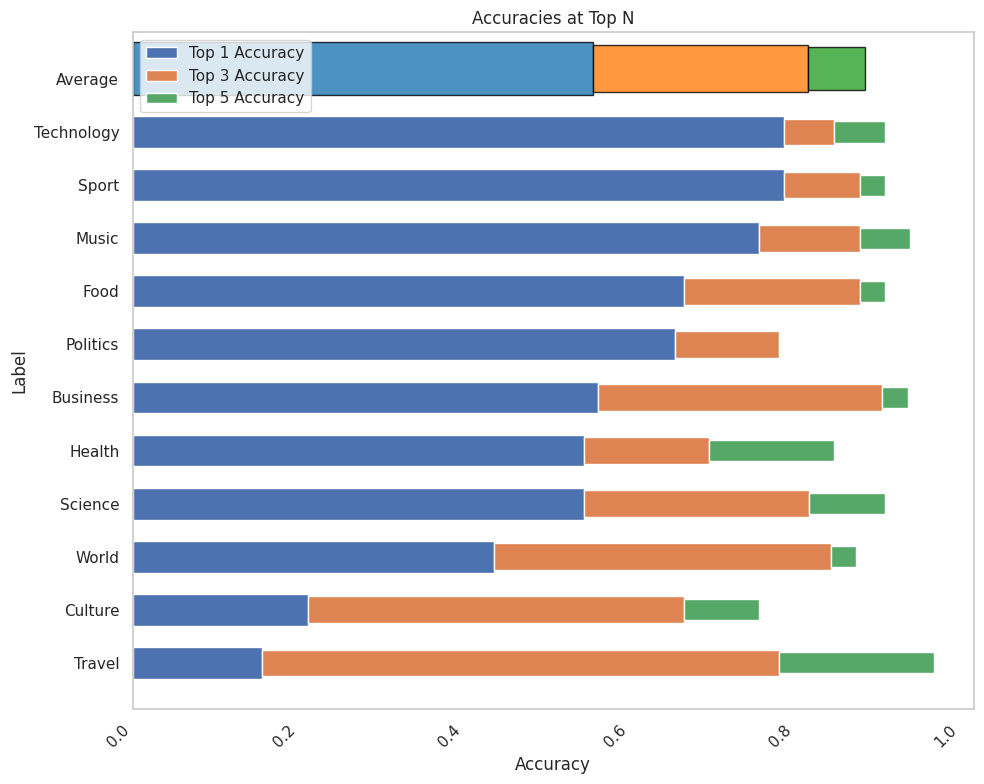

In [8]:
# ----------------------------- DISPLAY METRICS ------------------------------ #
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

result = pd.read_csv(
    os.path.join(
        pwd,
        "results",
        "topic_classification",
        "ZeroShot",
        "flaubert_predictions.csv",
    )
)
result["labels"] = result["labels"].apply(lambda x: eval(x))
result["scores"] = result["scores"].apply(lambda x: eval(x))


def is_in_top_n(label: str, n: int = 1) -> pd.Series:
    return result[result["label"] == label]["labels"].apply(lambda x: label in x[:n])


metrics = {}
for label in result["label"].unique():
    metrics[label] = {
        "accuracy@1": is_in_top_n(label, 1).mean(),
        "accuracy@3": is_in_top_n(label, 3).mean(),
        "accuracy@5": is_in_top_n(label, 5).mean(),
    }
metrics["Average"] = {
    "accuracy@1": result.apply(lambda x: x["label"] in x["labels"][:1], axis=1).mean(),
    "accuracy@3": result.apply(lambda x: x["label"] in x["labels"][:3], axis=1).mean(),
    "accuracy@5": result.apply(lambda x: x["label"] in x["labels"][:5], axis=1).mean(),
}

metrics = pd.DataFrame(metrics).T
metrics = metrics.sort_values("accuracy@1", ascending=True)

# Move Average row to the top
metrics = pd.concat([metrics.drop("Average"), metrics.loc[["Average"]]])

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "flaubert_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
metrics.to_csv(path)

display(metrics)

# Calculate precision, recall and f1-score
precision = precision_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
recall = recall_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
f1 = f1_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
classification_metrics = pd.DataFrame(
    {
        "accuracy": [metrics.loc["Average", "accuracy@1"]],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1],
    },
    index=["Flaubert-pretrained"],
)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "Flaubert-pretrained_classification_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
classification_metrics.to_csv(path)

display(classification_metrics)

import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que le DataFrame 'metrics' est déjà créé et trié par 'accuracy@1'
# metrics.sort_values("accuracy@1", ascending=False)

# Réinitialiser l'index pour pouvoir utiliser la colonne des labels dans le graphique
metrics.reset_index(inplace=True)
metrics.rename(columns={"index": "Label"}, inplace=True)

# Nous utilisons seaborn pour un style de graphique amélioré
sns.set_theme(style="whitegrid")

# La taille du graphique peut être ajustée pour mieux s'adapter à vos données
plt.figure(figsize=(10, 8))

# Création d'un graphique à barres empilées
# bottom paramètre spécifie où la barre commence, donc nous empilons en additionnant la précision précédente
plt.barh(metrics["Label"], metrics["accuracy@1"], label="Top 1 Accuracy", height=0.6)
plt.barh(
    metrics["Label"],
    metrics["accuracy@3"] - metrics["accuracy@1"],
    label="Top 3 Accuracy",
    height=0.5,
    left=metrics["accuracy@1"],
)
plt.barh(
    metrics["Label"],
    metrics["accuracy@5"] - metrics["accuracy@3"],
    label="Top 5 Accuracy",
    height=0.4,
    left=metrics["accuracy@3"],
)

# Titre du graphique et étiquettes des axes
plt.title("Accuracies at Top N")
plt.xlabel("Accuracy")
plt.ylabel("Label")

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité si nécessaire
plt.xticks(rotation=45, ha="right")

# Ajout d'une légende
plt.legend()

# Utilisez plt.tight_layout() si vous constatez que les étiquettes sont coupées dans la sortie finale
plt.tight_layout()

# Remove grid
plt.grid(False)

# Give specific color to first bar
plt.gca().get_children()[11].set(
    color="#1f77b4", alpha=0.8, edgecolor="black", height=1
)
plt.gca().get_children()[23].set(
    color="#ff7f0e", alpha=0.8, edgecolor="black", height=0.9
)
plt.gca().get_children()[35].set(
    color="#2ca02c", alpha=0.8, edgecolor="black", height=0.8
)

# Affichage du graphique
plt.show()

## mDeBERTa-v3

[mDeBERTa-v3](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7) est un modèle multilangue préentrainé qui peut-être utilisé pour de la classification zero-shot. Nous allons évaluer ses performances sur notre jeu de données.

In [10]:
import pandas as pd
from transformers import pipeline

# Charger le modèle zero-shot
classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
    device="cuda",
)

test_dataset = pd.read_csv(
    os.path.join(pwd, "results", "topic_classification", "DataPreparation", "test.csv")
)

labels = test_dataset["topic"].unique().tolist()

# Diviser les données en lots pour les prédictions par batch
batch_size = 64
batches = [
    test_dataset[i : i + batch_size]
    for i in range(0, test_dataset.shape[0], batch_size)
]

# Effectuer des prédictions par batch
predictions = []
for batch in batches:
    batch_texts = batch["text"].tolist()
    batch_predictions = classifier(
        batch_texts, labels, multi_label=False, batch_size=batch_size
    )
    predictions.extend(batch_predictions)

# Create results dataframe
result = pd.DataFrame(predictions)
result["label"] = test_dataset["topic"].tolist()

# Save results
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "mDeBERTa-v3-base-mnli-xnli_predictions.csv",
)
## Create folder if it does not exist
os.makedirs(os.path.dirname(path), exist_ok=True)
result.to_csv(path, index=False)

result

,sequence,labels,scores,label
0,Mondial 1998 : un bout de ligne de but de la f...,"[Sport, Politics, Business, Culture, Technolog...","[0.14496000111103058, 0.12220186740159988, 0.1...",Sport
1,Collomb force Macron à accepter sa démission :...,"[Politics, World, Business, Music, Travel, Tec...","[0.45804399251937866, 0.14648544788360596, 0.0...",Politics
2,Neil Young dévoile le tracklisting de ses Arch...,"[Music, Food, Culture, World, Business, Travel...","[0.23993229866027832, 0.11080344766378403, 0.1...",Music
3,Espagne: nouvelle blessure pour Diego Costa et...,"[Sport, Health, Business, Travel, Politics, Wo...","[0.13377977907657623, 0.11399109661579132, 0.1...",Sport
4,Une journaliste australienne détenue en Chine ...,"[Business, Politics, World, Travel, Technology...","[0.13368982076644897, 0.1324317306280136, 0.12...",World
...,...,...,...,...
354,"Fila, phénix du sportswear, s'impose sur la pl...","[World, Sport, Culture, Business, Politics, Mu...","[0.24013729393482208, 0.14842532575130463, 0.1...",Sport
355,"Le poème du lundi : aujourd'hui, «ta belle éte...","[Culture, World, Travel, Food, Health, Sport, ...","[0.17389310896396637, 0.16143985092639923, 0.1...",Culture
356,Kanye West aurait-il dévoilé un premier extrai...,"[Music, World, Culture, Travel, Food, Health, ...","[0.3557138741016388, 0.20771142840385437, 0.09...",Music
357,Ce qu’il vaut mieux savoir avant de (re)faire ...,"[Health, Sport, World, Technology, Science, Cu...","[0.4933668375015259, 0.26767364144325256, 0.03...",Sport


,accuracy@1,accuracy@3,accuracy@5
World,0.125000,0.656250,0.843750
Science,0.242424,0.484848,0.636364
Sport,0.303030,0.787879,0.939394
Culture,0.303030,0.727273,0.818182
Health,0.393939,0.757576,0.878788
Business,0.437500,0.843750,0.968750
Travel,0.437500,0.875000,0.937500
Technology,0.454545,0.666667,0.787879
Food,0.575758,0.909091,0.939394
Music,0.818182,0.969697,0.969697


,accuracy,precision,recall,f1
mDeBERTa-v3-base-mnli-xnli,0.451253,0.451253,0.451253,0.451253


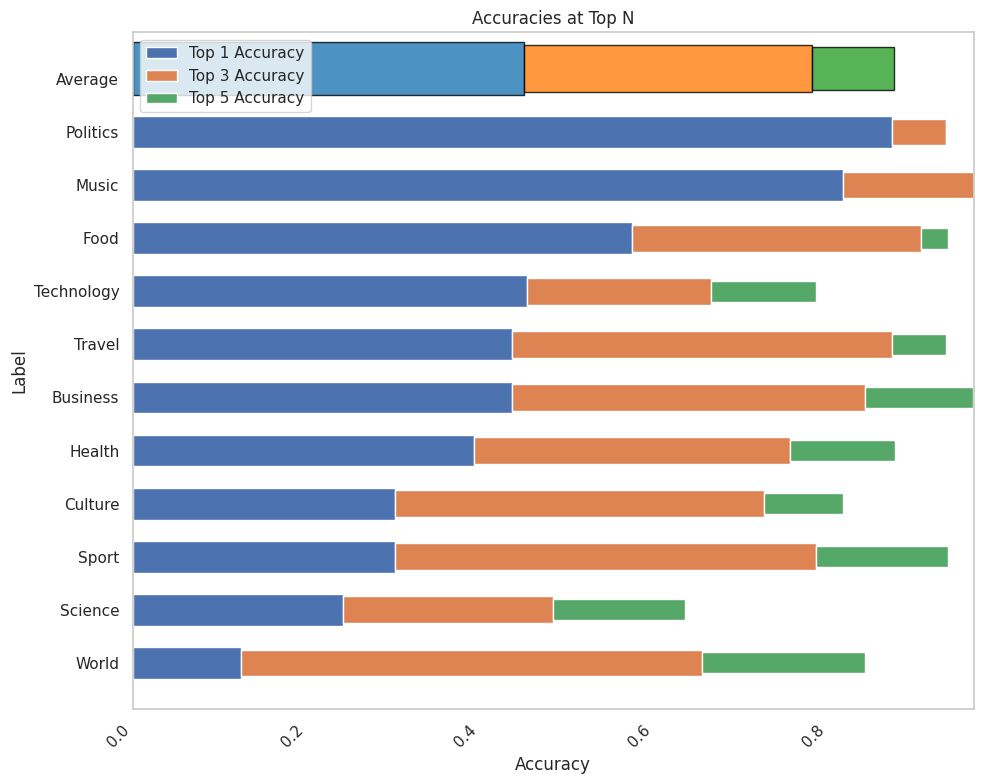

In [11]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

result = pd.read_csv(
    os.path.join(
        pwd,
        "results",
        "topic_classification",
        "ZeroShot",
        "mDeBERTa-v3-base-mnli-xnli_predictions.csv",
    ),
    sep=",",
    index_col=None,
    header=0,
)
result["labels"] = result["labels"].apply(eval)
result["scores"] = result["scores"].apply(eval)


def is_in_top_n(label: str, n: int = 1) -> pd.Series:
    return result[result["label"] == label]["labels"].apply(lambda x: label in x[:n])


metrics = {}
for label in result["label"].unique():
    metrics[label] = {
        "accuracy@1": is_in_top_n(label, 1).mean(),
        "accuracy@3": is_in_top_n(label, 3).mean(),
        "accuracy@5": is_in_top_n(label, 5).mean(),
    }
metrics["Average"] = {
    "accuracy@1": result.apply(lambda x: x["label"] in x["labels"][:1], axis=1).mean(),
    "accuracy@3": result.apply(lambda x: x["label"] in x["labels"][:3], axis=1).mean(),
    "accuracy@5": result.apply(lambda x: x["label"] in x["labels"][:5], axis=1).mean(),
}

metrics = pd.DataFrame(metrics).T
metrics = metrics.sort_values("accuracy@1", ascending=True)

# Move Average row to the top
metrics = pd.concat([metrics.drop("Average"), metrics.loc[["Average"]]])

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "mDeBERTa-v3-base-mnli-xnli_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
metrics.to_csv(path)

display(metrics)

# Calculate precision, recall and f1-score
precision = precision_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
recall = recall_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
f1 = f1_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
    average="micro",
)
classification_metrics = pd.DataFrame(
    {
        "accuracy": [metrics.loc["Average", "accuracy@1"]],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1],
    },
    index=["mDeBERTa-v3-base-mnli-xnli"],
)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "ZeroShot",
    "mDeBERTa-v3-base-mnli-xnli_classification_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
classification_metrics.to_csv(path)

display(classification_metrics)

import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que le DataFrame 'metrics' est déjà créé et trié par 'accuracy@1'
# metrics.sort_values("accuracy@1", ascending=False)

# Réinitialiser l'index pour pouvoir utiliser la colonne des labels dans le graphique
metrics.reset_index(inplace=True)
metrics.rename(columns={"index": "Label"}, inplace=True)

# Nous utilisons seaborn pour un style de graphique amélioré
sns.set_theme(style="whitegrid")

# La taille du graphique peut être ajustée pour mieux s'adapter à vos données
plt.figure(figsize=(10, 8))

# Création d'un graphique à barres empilées
# bottom paramètre spécifie où la barre commence, donc nous empilons en additionnant la précision précédente
plt.barh(metrics["Label"], metrics["accuracy@1"], label="Top 1 Accuracy", height=0.6)
plt.barh(
    metrics["Label"],
    metrics["accuracy@3"] - metrics["accuracy@1"],
    label="Top 3 Accuracy",
    height=0.5,
    left=metrics["accuracy@1"],
)
plt.barh(
    metrics["Label"],
    metrics["accuracy@5"] - metrics["accuracy@3"],
    label="Top 5 Accuracy",
    height=0.4,
    left=metrics["accuracy@3"],
)

# Titre du graphique et étiquettes des axes
plt.title("Accuracies at Top N")
plt.xlabel("Accuracy")
plt.ylabel("Label")

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité si nécessaire
plt.xticks(rotation=45, ha="right")

# Ajout d'une légende
plt.legend()

# Utilisez plt.tight_layout() si vous constatez que les étiquettes sont coupées dans la sortie finale
plt.tight_layout()

# Remove grid
plt.grid(False)

# Give specific color to first bar
plt.gca().get_children()[11].set(
    color="#1f77b4", alpha=0.8, edgecolor="black", height=1
)
plt.gca().get_children()[23].set(
    color="#ff7f0e", alpha=0.8, edgecolor="black", height=0.9
)
plt.gca().get_children()[35].set(
    color="#2ca02c", alpha=0.8, edgecolor="black", height=0.8
)

# Affichage du graphique
plt.show()